In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import timeit
from rpl import RadarSignalProcessing
import sys
from DBReader.DBReader import SyncReader

## 1. Load the dataset

In [2]:
root_folder = '/Volumes/ELEMENTS/datasets/radial/RECORD@2020-11-22_12.45.05'
db = SyncReader(root_folder,tolerance=20000)

-------------------------------------------------------------------------
- Sensors available:
-     radar_ch2
-     camera
-     radar_ch1
-     radar_ch0
-     can
-     gps
-     radar_ch3
-     scala
-
- You might use function "setSensorFilters" to select sensors you want to read!
-------------------------------------------------------------------------
Total tolerance errors:  18.314606741573034 %
Total corrupted frames:  1.1235955056179776 %


In [3]:
# use print_info function to get all the details of the database content
db.print_info()
print('')

# Create an iterator on the dataset
ite = iter(db)

Available sensors:
# Sensor:  radar_ch2
	- filename:  /Volumes/ELEMENTS/datasets/radial/RECORD@2020-11-22_12.45.05/RECORD@2020-11-22_12.45.05_radar_ch2.bin
	- Nb Samples:  5583
	- Duration:  178 sec
	- Update rate:  31.92029374888053 ms
# Sensor:  camera
	- filename:  /Volumes/ELEMENTS/datasets/radial/RECORD@2020-11-22_12.45.05/RECORD@2020-11-22_12.45.05_camera.mjpg
	- Nb Samples:  8088
	- Duration:  178 sec
	- Update rate:  22.052941641938677 ms
# Sensor:  radar_ch1
	- filename:  /Volumes/ELEMENTS/datasets/radial/RECORD@2020-11-22_12.45.05/RECORD@2020-11-22_12.45.05_radar_ch1.bin
	- Nb Samples:  5584
	- Duration:  178 sec
	- Update rate:  31.91421919770774 ms
# Sensor:  radar_ch0
	- filename:  /Volumes/ELEMENTS/datasets/radial/RECORD@2020-11-22_12.45.05/RECORD@2020-11-22_12.45.05_radar_ch0.bin
	- Nb Samples:  5582
	- Duration:  178 sec
	- Update rate:  31.926549623790752 ms
# Sensor:  can
	- filename:  /Volumes/ELEMENTS/datasets/radial/RECORD@2020-11-22_12.45.05/RECORD@2020-11-22_12.4

dict_keys(['radar_ch3', 'radar_ch0', 'radar_ch1', 'radar_ch2', 'camera', 'can', 'scala'])
18382


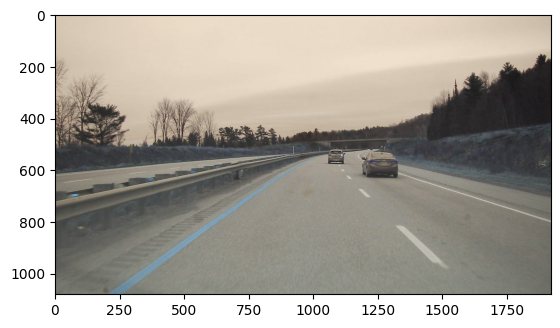

In [4]:
sample = db.GetSensorData(58)
plt.imshow(sample['camera']['data'])
print(sample.keys())
print(sample['scala']['sample_number'])

## 2. RadarSignalProcessing to compute Point Cloud 

In [5]:
CALIB_PATH = '/Volumes/ELEMENTS/datasets/radial/CalibrationTable.npy'

In [6]:
RSP = RadarSignalProcessing(CALIB_PATH, method='PC')

CPU will be used to execute the processing


## 3. RadarSignalProcessing to compute Doppler Spectrums

In [7]:
RSP = RadarSignalProcessing(CALIB_PATH, method='RD')

CPU will be used to execute the processing


In [8]:
%time rd=RSP.run(sample['radar_ch0']['data'],sample['radar_ch1']['data'],sample['radar_ch2']['data'],sample['radar_ch3']['data'])

CPU times: user 190 ms, sys: 78.2 ms, total: 269 ms
Wall time: 95.3 ms


torch.Size([512, 256, 16]) It has 16 channels, one for each Rx antenna


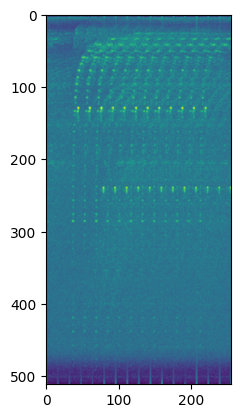

In [9]:
print(rd.shape,'It has 16 channels, one for each Rx antenna')
plt.imshow(np.log10(np.sum(np.abs(rd.cpu().numpy()), axis=2)))

# 3.1 View Individual Channels
To check if specific antennas have stronger or cleaner signals:

/var/folders/wh/181dmx3d2v94m8cyv4ny1s_w0000gn/T/ipykernel_70041/2807305757.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(np.log10(np.abs(rd[:, :, i]) + 1e-6), aspect='auto')


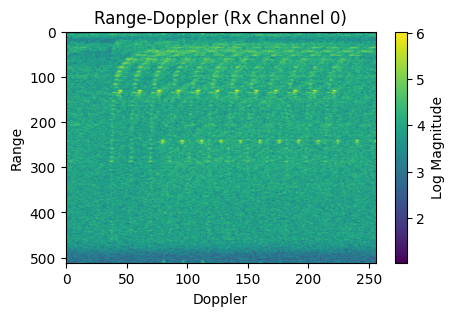

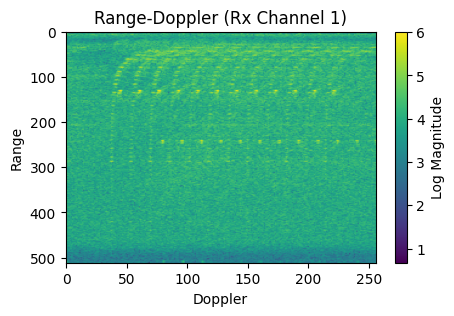

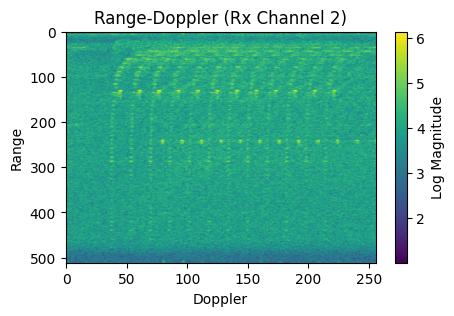

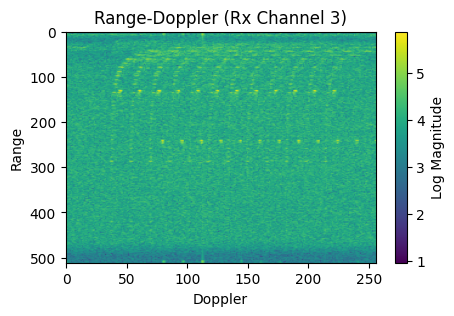

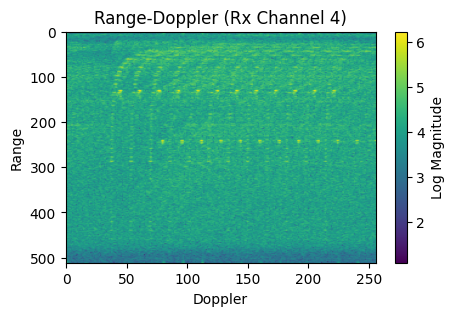

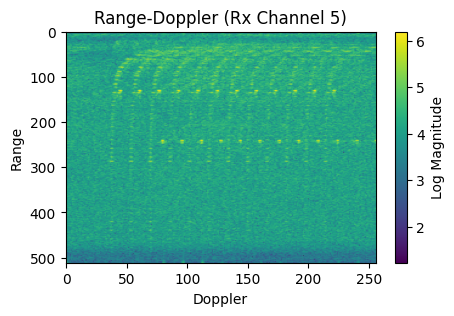

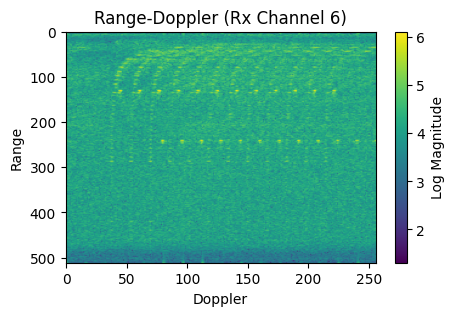

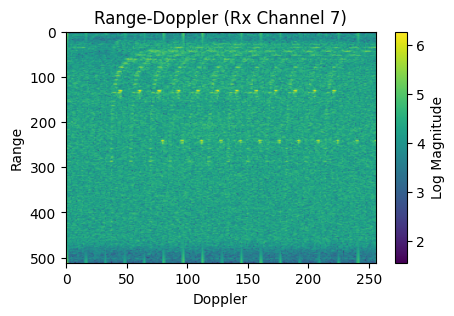

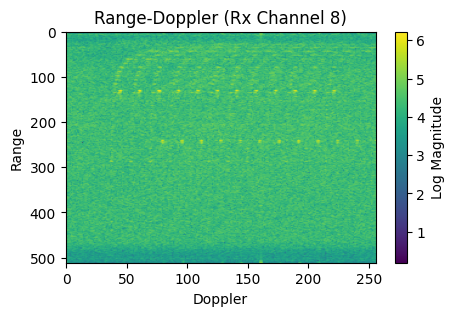

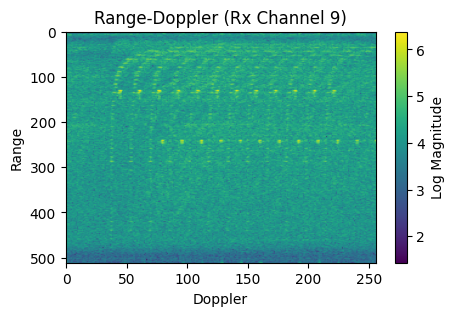

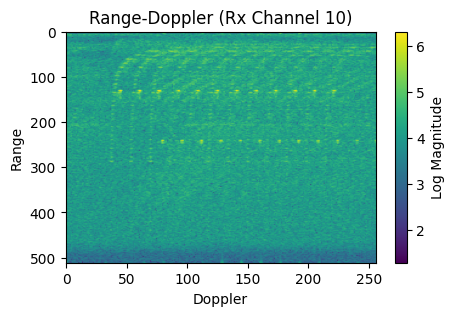

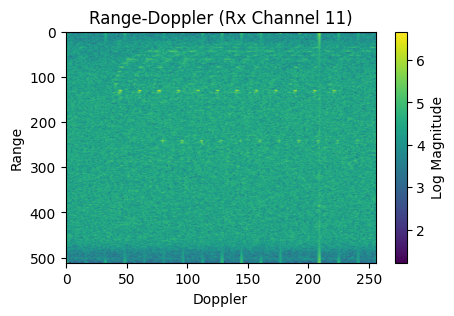

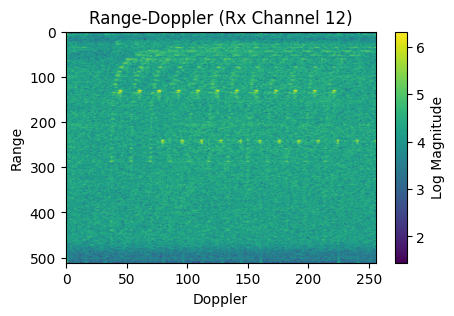

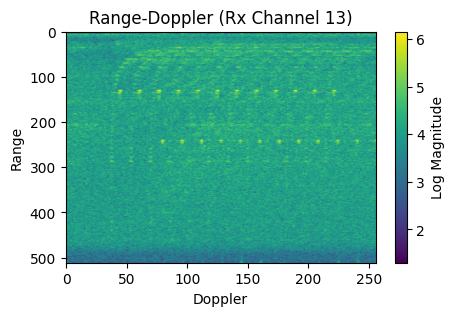

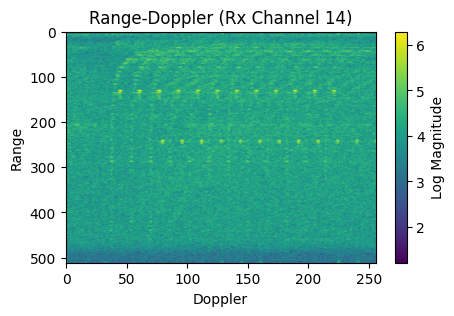

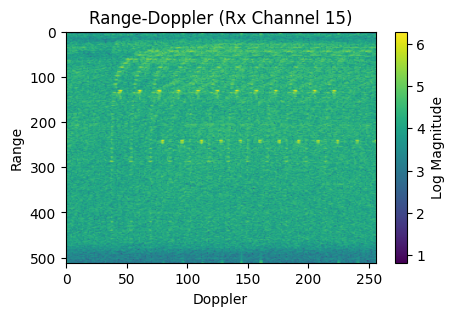

In [10]:
for i in range(rd.shape[2]):
    plt.figure(figsize=(5, 3))
    plt.imshow(np.log10(np.abs(rd[:, :, i]) + 1e-6), aspect='auto')
    plt.title(f'Range-Doppler (Rx Channel {i})')
    plt.xlabel('Doppler')
    plt.ylabel('Range')
    plt.colorbar(label='Log Magnitude')
    plt.show()

# 3.2. Principal Component Projection (PCA across channels)
This can reveal dominant motion patterns across antennas PCA is useful if you want to reduce the dimensionality and capture the most significant variance across channels:


/var/folders/wh/181dmx3d2v94m8cyv4ny1s_w0000gn/T/ipykernel_70041/680875318.py:7: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  principal_component = pca.fit_transform(np.abs(rd_flat))


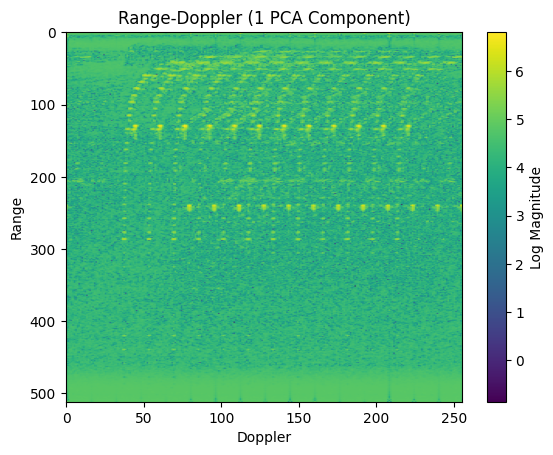

In [11]:
from sklearn.decomposition import PCA

# Flatten Range-Doppler into a 2D matrix: (num_pixels, num_channels)
rd_flat = rd.reshape(-1, rd.shape[2])
components = 1
pca = PCA(n_components=components)
principal_component = pca.fit_transform(np.abs(rd_flat))

# Reshape back to 2D image
# Reshape back to 2D for visualization (range x doppler x components)
pca_image = principal_component.reshape(512, 256, components)
# pc_image = principal_component.reshape(rd.shape[0], rd.shape[1])

plt.imshow(np.log10(np.abs(pca_image) + 1e-6), aspect='auto')
plt.title(f'Range-Doppler ({components} PCA Component)')
plt.xlabel('Doppler')
plt.ylabel('Range')
plt.colorbar(label='Log Magnitude')
plt.show()

# 3.3. Complex Coherent Sum (Phase-Sensitive)
This keeps phase info and might emphasize directional targets:

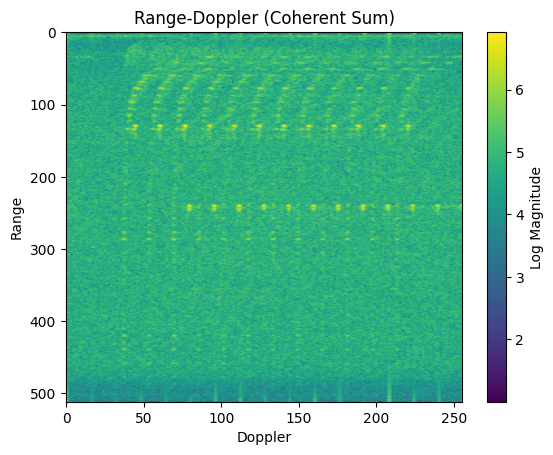

In [12]:
coherent_sum = np.sum(rd.numpy(), axis=2)  # Complex sum across Rx antennas
plt.imshow(np.log10(np.abs(coherent_sum) + 1e-6), aspect='auto')
plt.title('Range-Doppler (Coherent Sum)')
plt.xlabel('Doppler')
plt.ylabel('Range')
plt.colorbar(label='Log Magnitude')
plt.show()

# 3.4. Background Subtraction (Clutter Removal)
To highlight moving targets:

/var/folders/wh/181dmx3d2v94m8cyv4ny1s_w0000gn/T/ipykernel_70041/3538894232.py:11: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(np.sum(rd_detrended, axis=2) + 1e-6),


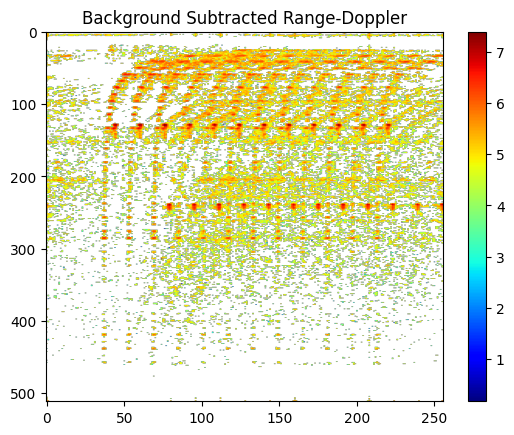

In [13]:
rd = rd.cpu().numpy()  # Convert to numpy for further processing
# Mean across slow time (or if you have a time dimension, use that instead)
# Average over a portion of the data to estimate background
# Mean across range and doppler bins
background = np.mean(np.abs(rd), axis=(0, 1))

# Subtract background from each channel
rd_detrended = np.abs(rd) - background.reshape(1, 1, 16)

# Visualize the result
plt.imshow(np.log10(np.sum(rd_detrended, axis=2) + 1e-6),
           aspect='auto', cmap='jet')
plt.title('Background Subtracted Range-Doppler')
plt.colorbar()
plt.show()

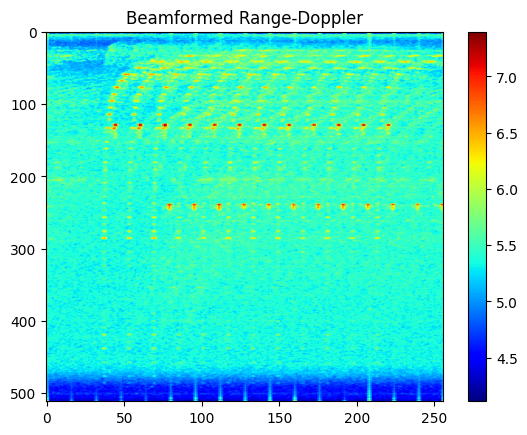

In [14]:
# Example beamforming by averaging channels with a directional delay (simple)
# You can extend this to more sophisticated beamforming techniques.
directional_sum = np.sum(np.abs(rd), axis=2)  # Simple sum over all channels
rd_bf = directional_sum
plt.imshow(np.log10(directional_sum + 1e-6), aspect='auto', cmap='jet')
plt.title('Beamformed Range-Doppler')
plt.colorbar()
plt.show()

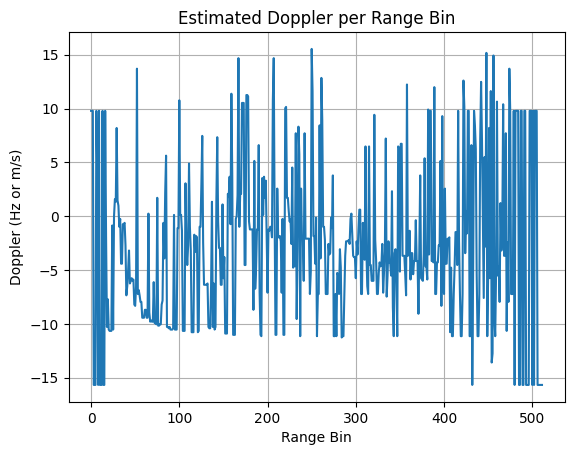

In [15]:
# Assuming `rd_bf` is your beamformed Range-Doppler map (magnitude or power)
# Optional: convert to Hz or m/s
doppler_bin_time = 0.03192  # seconds (31.92 ms)
num_doppler_bins = rd_bf.shape[1]
doppler_axis = np.fft.fftshift(np.fft.fftfreq(
    num_doppler_bins, d=doppler_bin_time))

# Example for 77 GHz radar (λ ≈ 3.9 mm)
fc = 77e9  # carrier frequency in Hz
c = 3e8    # speed of light in m/s
lambda_radar = c / fc

doppler_velocity_axis = doppler_axis * lambda_radar / 2

# Index of max Doppler per range
true_doppler_indices = np.argmax(rd_bf, axis=1)
true_doppler_values = doppler_axis[true_doppler_indices]
true_doppler_velocity = doppler_velocity_axis[true_doppler_indices]  # m/s


# Plot range vs. true Doppler value
plt.plot(true_doppler_values)
plt.title("Estimated Doppler per Range Bin")
plt.xlabel("Range Bin")
plt.ylabel("Doppler (Hz or m/s)")
plt.grid()
plt.show()

In [16]:
# Compute Doppler Spectrum for a Single Channel
numerator = np.sum(rd_bf * doppler_axis[None, :], axis=1)
denominator = np.sum(rd_bf + 1e-8, axis=1)
doppler_centroids = numerator / denominator


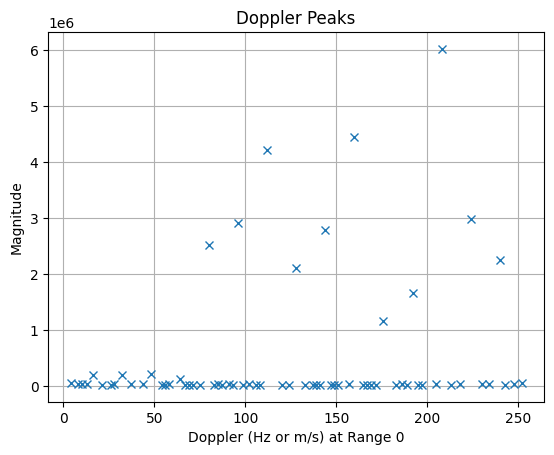

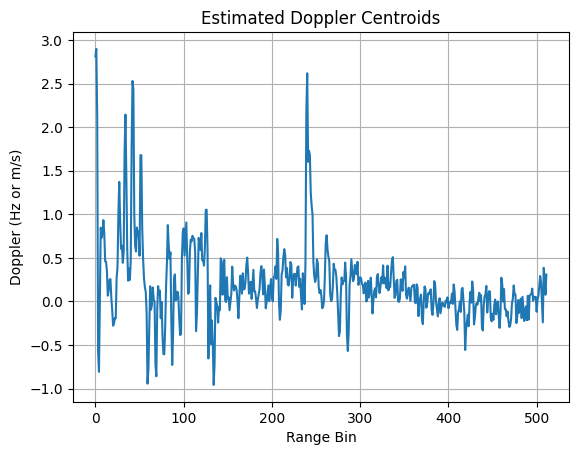

In [17]:
from scipy.signal import find_peaks
threshold = 0.1
for r in range(rd_bf.shape[0]):
    peaks, _ = find_peaks(rd_bf[r, :], height=threshold)  # tune threshold
    true_dopplers = doppler_axis[peaks]
    # Optionally store or plot
# # plot
# plt.plot(doppler_axis, rd_bf[0, :])
# plt.title("Range 0 Doppler Spectrum")

# plot true_dopplers
plt.plot(peaks, rd_bf[0, peaks], "x")
plt.xlabel("Doppler (Hz or m/s) at Range 0")
plt.ylabel("Magnitude")
plt.title("Doppler Peaks")
plt.grid()
plt.show()
# Plot the estimated Doppler centroids
plt.plot(doppler_centroids)
plt.title("Estimated Doppler Centroids")
plt.xlabel("Range Bin")
plt.ylabel("Doppler (Hz or m/s)")
plt.grid()

# Use the radar platform speed

In [18]:
from DBReader.DBReader.SensorsReaders import CANDecoder
# you can get also the odometry at a defined timestamp
timestamp = sample['camera']['timestamp']
# print(sample['camera'])

# print(sample['can']['data'][3])


# # you need to provide the dbc decoder
can_decoder = CANDecoder(
    '/Users/daniel/Idan/University/Masters/Thesis/2024/radar_sort/utils/T_FFTRadNet/RadIal/ADCProcessing/DBReader/examples/can_database.dbc')


def GetMostRecentOdometry(can_frames, decoder, time):

    # Steering: ID=485
    arr = np.array(can_frames['ID'])
    arr.sort()
    print(np.where(can_frames['ID'] == 485)[0])
    IDX = np.where(can_frames['ID'] == 485)[0]
    timediff = np.abs(can_frames['timestamp'][IDX] - time)
    id_steer = IDX[np.argmin(timediff)]
    message = decoder.decode([{'timestamp': can_frames['timestamp'][id_steer],
                             'ID': can_frames['ID'][id_steer].item(), 'DATA': can_frames['data'][id_steer]}])
    SteeringWheel = message[0]['signals']['Steering_Wheel_Angle_deg']

    # Yaw: 489
    IDX = np.where(can_frames['ID'] == 489)[0]
    timediff = np.abs(can_frames['timestamp'][IDX] - time)
    id_yaw = IDX[np.argmin(timediff)]
    message = decoder.decode([{'timestamp': can_frames['timestamp'][id_yaw],
                             'ID': can_frames['ID'][id_yaw].item(), 'DATA': can_frames['data'][id_yaw]}])
    YawRate = message[0]['signals']['YawRate_deg']

    # Speed: ID=1001
    IDX = np.where(can_frames['ID'] == 1001)[0]
    timediff = np.abs(can_frames['timestamp'][IDX] - time)
    id_speed = IDX[np.argmin(timediff)]
    message = decoder.decode([{'timestamp': can_frames['timestamp'][id_speed],
                             'ID': can_frames['ID'][id_speed].item(), 'DATA': can_frames['data'][id_speed]}])
    VehSpd = message[0]['signals']['Speed_kph']

    return SteeringWheel, YawRate, VehSpd


odometry = GetMostRecentOdometry(db.can_frames, can_decoder, timestamp)
# odometry = db.GetMostRecentOdometry(can_decoder, timestamp)
print('Speed (kph):', odometry[2])
print('Steering wheel angle (degree):', odometry[0])
print('yaw rate (degree/sec):', odometry[1])

[     4     23     44 ... 362645 362669 362683]
Speed (kph): 100.0
Steering wheel angle (degree): 12.5625
yaw rate (degree/sec): 2.5625


In [19]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1) Radar & platform parameters ---
v_ego_kph = odometry[2]
v_ego = v_ego_kph * (1000/3600)    # m/s
c = 3e8
f_c = 77e9                         # Hz
λ = c / f_c                        # radar wavelength [m]
PRI = 0.01356                      # seconds (13.56 ms update rate)
PRF = 1 / PRI                      # ≈ 73.75 Hz
N_D = rd_bf.shape[1]               # number of Doppler bins, e.g. 256

# Build the “wrapped” Doppler‐frequency axis in Hz:
doppler_freqs = np.fft.fftshift(np.fft.fftfreq(N_D, d=1/PRF))
#   This array runs from -PRF/2 .. +PRF/2 in steps of Δf = PRF/N_D

# --- 2) Suppose you already have a list of detections from Range–Azimuth ---
# Each detection is (range_index, azimuth_rad). For example:
#   dets = [(r0, theta0), (r1, theta1), ...]
#
# r_i is an integer in [0..N_R-1], theta_i is in radians ([-π/2 .. +π/2],
# where 0 = forward).

# For demonstration, let’s suppose you computed:
dets = [
    # (range_bin, azimuth_angle_in_radians)
    (50,  np.deg2rad(0.0)),  # e.g. a target straight ahead at range‐bin 50
    (120,  np.deg2rad(10.0)),  # e.g. another target at +10° at range‐bin 120
    # … etc …
]

# Pre‐allocate arrays to store results:
true_doppler_hz = np.zeros(len(dets), dtype=float)
true_velocity_mps = np.zeros(len(dets), dtype=float)  # m/s

for idx, (r_i, theta_i) in enumerate(dets):
    # --- 3) Find the Doppler‐bin index k_i of the peak at range r_i ---
    # take magnitude if rd_bf is complex
    dop_row = np.abs(rd_bf[r_i, :])
    # which Doppler bin is the strongest?
    k_i = np.argmax(dop_row)
    f_wrapped = doppler_freqs[k_i]           # Doppler in [−PRF/2 .. +PRF/2]

    # --- 4) Compute ego‐induced Doppler at azimuth θ_i ---
    f_ego_i = -2 * v_ego * np.cos(theta_i) / λ

    # --- 5) Search for the integer fold n that best aligns f_wrapped + n*PRF to f_ego_i ---
    best_n, best_diff = 0, np.inf
    for n_test in range(-3, +4):   # check n = -3,..,+3
        f_candidate = f_wrapped + n_test * PRF
        diff = abs(f_candidate - f_ego_i)
        if diff < best_diff:
            best_diff = diff
            best_n = n_test

    # Unwrapped Doppler that (if static) would match the ego‐motion:
    f_unwrapped = f_wrapped + best_n * PRF
    true_doppler_hz[idx] = f_unwrapped

    # --- 6) Subtract out the ego‐induced shift to get target radial Doppler ---
    # If target is truly static, f_unwrapped ≈ f_ego_i ⇒ v_targ ≈ 0.
    # If target is moving, then:
    #   f_unwrapped = (2/λ)*(v_targ*cos(theta_i) - v_ego*cos(theta_i)).
    # so (f_unwrapped - f_ego_i) = (2/λ)*(v_targ * cos(theta_i)).
    fd_diff = f_unwrapped - f_ego_i
    # => v_targ * cos(theta_i) = (λ/2)*fd_diff  ⇒ v_targ = (λ/2)*(fd_diff / cos θ_i).

    v_targ_estimated = (λ/2) * (fd_diff / np.cos(theta_i))
    true_velocity_mps[idx] = v_targ_estimated

    print(f"Det {idx:2d}: r={r_i}, θ={np.rad2deg(theta_i):5.1f}°  |  "
          f"f_wrapped={f_wrapped:+6.2f} Hz  n={best_n}  f_unwrapped={f_unwrapped:+7.2f} Hz  |  "
          f"v_target ≈ {v_targ_estimated:6.2f} m/s"
          )

# After the loop, true_doppler_hz[i] is the “unfolded” Doppler for detection i,
# and true_velocity_mps[i] is the estimated target radial speed in m/s.

Det  0: r=50, θ=  0.0°  |  f_wrapped=-19.59 Hz  n=-3  f_unwrapped=-240.83 Hz  |  v_target ≈  27.31 m/s
Det  1: r=120, θ= 10.0°  |  f_wrapped= -4.61 Hz  n=-3  f_unwrapped=-225.85 Hz  |  v_target ≈  27.33 m/s


Det  0:  r=240,  θ= -5.3°  |  f_wrapped= -4.90 Hz  n=-192  f_unwrapped=-14164.19 Hz  |  v_target ≈   0.07 m/s
Det  1:  r=118,  θ=-10.5°  |  f_wrapped= -7.78 Hz  n=-190  f_unwrapped=-14019.58 Hz  |  v_target ≈   0.00 m/s


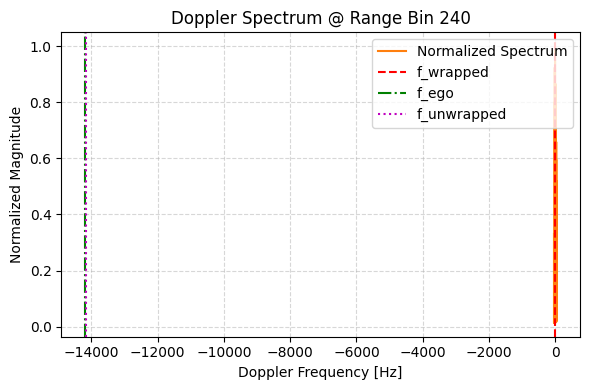

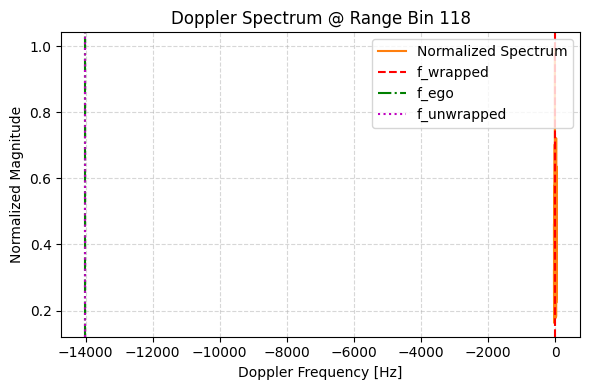

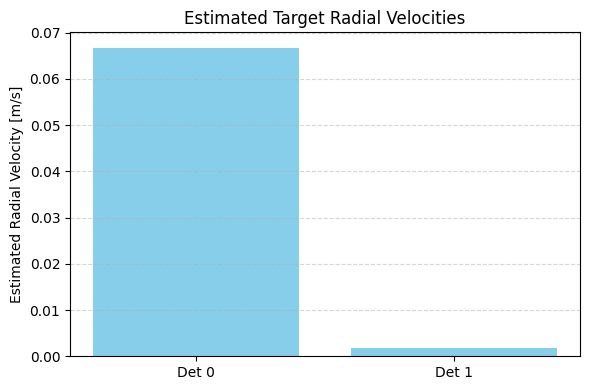

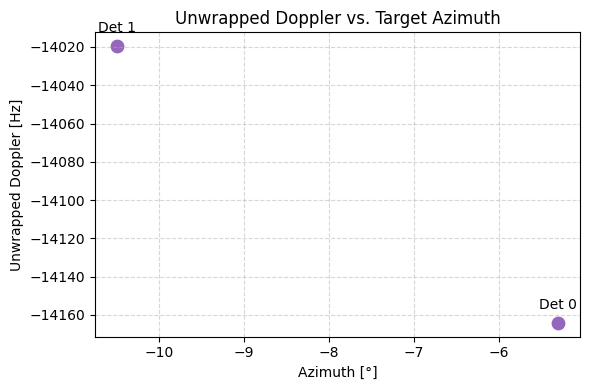

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# A) Re‐compute and store intermediate results into arrays
# ---------------------------------------------------------

# (1) Radar & ego parameters (same as before)
v_ego_kph = odometry[2]
v_ego = v_ego_kph * (1000/3600)    # convert kph → m/s
c = 3e8
f_c = 77e9                         # Hz
λ = c / f_c                        # radar wavelength [m]
PRI = 0.01356                      # seconds (13.56 ms)
PRF = 1 / PRI                      # ≈ 73.75 Hz
N_D = rd_bf.shape[1]               # number of Doppler bins (e.g. 256)
N_R = rd_bf.shape[0]               # number of range bins (e.g. 512)

# (2) Build the “wrapped” Doppler‐frequency axis in Hz:
doppler_freqs = np.fft.fftshift(np.fft.fftfreq(N_D, d=1/PRF))
#   => runs from -PRF/2 .. +PRF/2 in steps of PRF/N_D

# (3) Suppose this is your list of detections:
#     each entry is (range_bin_index, azimuth_in_radians)
#    (You already used these when computing f_wrapped_arr, etc.)
#    For demonstration, I’ll assume you defined:
#    dets = [(50, np.deg2rad(0.0)), (120, np.deg2rad(10.0)), …]
#    In practice, replace “dets” with whatever you have.
#
#    (If you already ran your loop, simply skip re‐defining dets.)

# Example (if you need it):
# dets = [
#     (50,  np.deg2rad(0.0)),   # target straight ahead at range bin 50
#     (120, np.deg2rad(10.0)),  # another target at +10º at range bin 120
#     # … more detections …
# ]
dets = [
    # (50,  np.deg2rad(0.0)),   # target straight ahead at range bin 50
    # (120, np.deg2rad(10.0)),  # another target at +10º at range bin 120
    (int((48.3/103) * 512),  np.deg2rad(-5.3)),
    (int((23.9/103) * 512), np.deg2rad(-10.5)),
]




num_dets = len(dets)

# Pre‐allocate arrays to store each value for every detection
f_wrapped_arr = np.zeros(num_dets)
f_ego_arr = np.zeros(num_dets)
f_unwrapped_arr = np.zeros(num_dets)
n_arr = np.zeros(num_dets, dtype=int)
true_velocity_mps = np.zeros(num_dets)

for idx, (r_i, theta_i) in enumerate(dets):
    # 3.1) Extract the Doppler row at that range bin
    dop_row = np.abs(rd_bf[r_i, :])
    k_i = np.argmax(dop_row)                 # Doppler‐bin index of peak
    f_wrapped = doppler_freqs[k_i]           # this is in [−PRF/2 .. +PRF/2]
    f_wrapped_arr[idx] = f_wrapped

    # 3.2) Compute ego‐induced Doppler at azimuth θ_i
    f_ego_i = -2 * v_ego * np.cos(theta_i) / λ
    f_ego_arr[idx] = f_ego_i

    # 3.3) Search for integer n so that f_wrapped + n*PRF ≈ f_ego_i (static‐clutter guess)
    best_n, best_diff = 0, np.inf
    for n_test in range(-200, 201):
        f_candidate = f_wrapped + n_test * PRF
        diff = abs(f_candidate - f_ego_i)
        if diff < best_diff:
            best_diff = diff
            best_n = n_test

    n_arr[idx] = best_n
    f_unwrapped = f_wrapped + best_n * PRF
    f_unwrapped_arr[idx] = f_unwrapped

    # 3.4) Finally, subtract the ego component to get the target’s radial Doppler
    fd_diff = f_unwrapped - f_ego_i
    v_targ_estimated = (λ / 2) * (fd_diff / np.cos(theta_i))
    true_velocity_mps[idx] = v_targ_estimated

    # (Optional) Print out the numbers, just like you saw:
    print(
        f"Det {idx:2d}:  r={r_i},  θ={np.rad2deg(theta_i):5.1f}°  |  "
        f"f_wrapped={f_wrapped:+6.2f} Hz  n={best_n}  f_unwrapped={f_unwrapped:+7.2f} Hz  |  "
        f"v_target ≈ {v_targ_estimated:6.2f} m/s"
    )


# ---------------------------------------------------------
# B) VISUALIZATION BLOCKS
# ---------------------------------------------------------

# 1) Plot each detection’s Doppler spectrum (normalized)
#    with vertical lines marking f_wrapped, f_ego, and f_unwrapped.
for idx, (r_i, theta_i) in enumerate(dets):
    plt.figure(figsize=(6, 4))
    dop_row = np.abs(rd_bf[r_i, :])
    dop_row_norm = dop_row / dop_row.max()

    plt.plot(doppler_freqs, dop_row_norm,
             color='tab:orange', label='Normalized Spectrum')
    plt.axvline(f_wrapped_arr[idx], color='r',
                linestyle='--',   label='f_wrapped')
    plt.axvline(f_ego_arr[idx],     color='g', linestyle='-.',   label='f_ego')
    plt.axvline(f_unwrapped_arr[idx], color='m',
                linestyle=':', label='f_unwrapped')

    plt.title(f'Doppler Spectrum @ Range Bin {r_i}')
    plt.xlabel('Doppler Frequency [Hz]')
    plt.ylabel('Normalized Magnitude')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()


# 2) Bar chart of “Estimated Target Radial Velocities”
plt.figure(figsize=(6, 4))
indices = np.arange(num_dets)
plt.bar(indices, true_velocity_mps, color='skyblue')
plt.xticks(indices, [f'Det {i}' for i in indices])
plt.ylabel('Estimated Radial Velocity [m/s]')
plt.title('Estimated Target Radial Velocities')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


# 3) Scatter: Unwrapped Doppler vs. Azimuth (in degrees)
azimuth_deg = [np.rad2deg(theta) for (_, theta) in dets]
plt.figure(figsize=(6, 4))
plt.scatter(azimuth_deg, f_unwrapped_arr, s=80, c='tab:purple')
for i, txt in enumerate(indices):
    plt.annotate(f'Det {i}',
                 (azimuth_deg[i], f_unwrapped_arr[i]),
                 textcoords="offset points", xytext=(0, 10), ha='center')

plt.xlabel('Azimuth [°]')
plt.ylabel('Unwrapped Doppler [Hz]')
plt.title('Unwrapped Doppler vs. Target Azimuth')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Det  0:  r=240, θ= -5.3°  |  f_wrapped=-626.84 Hz  n= -1  f_unwrapped=-10066.37 Hz  |  v_target ≈   8.08 m/s
Det  1:  r=118, θ=-10.5°  |  f_wrapped=-995.58 Hz  n= -1  f_unwrapped=-10435.10 Hz  |  v_target ≈   7.10 m/s


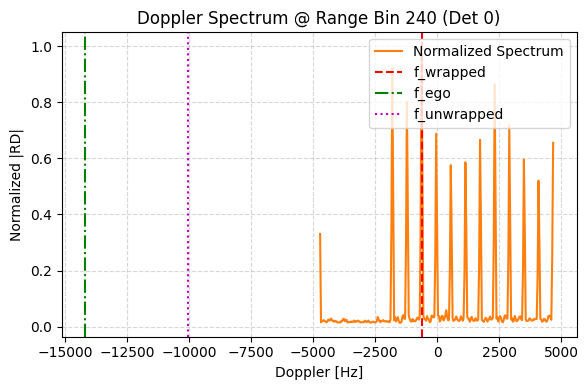

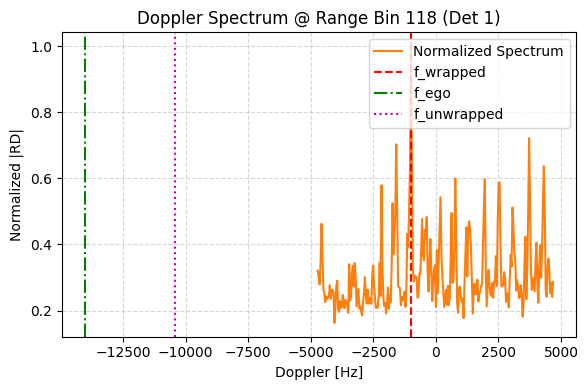

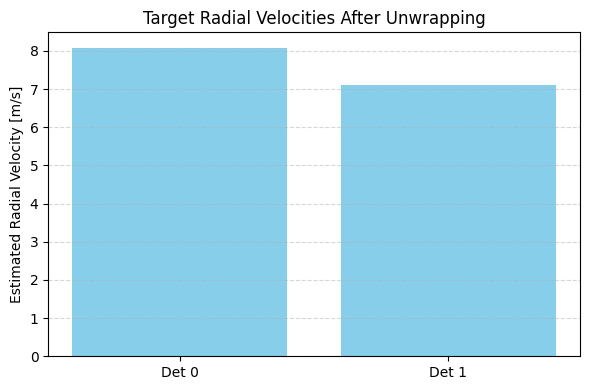

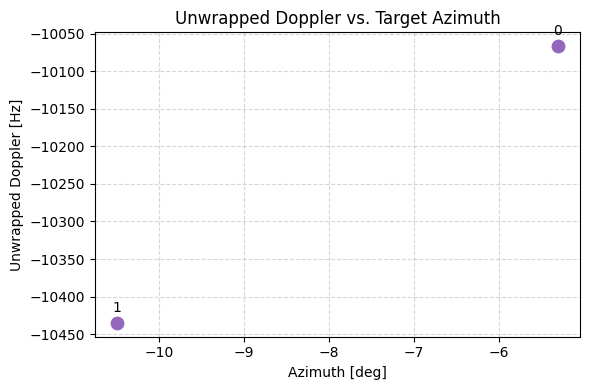

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# 1) Radar & Platform Parameters (with “correct” PRF_chirp)
# ---------------------------------------------------------

# (a) Ego speed from CAN (kph → m/s)
v_ego_kph = odometry[2]                # e.g. 93.6875 kph
v_ego = v_ego_kph * (1000/3600)        # ≈ 26.02 m/s

# (b) Radar wavelength (for a 77 GHz sensor)
c = 3e8
f_c = 77e9                             # 77 GHz
λ = c / f_c                            # ≈ 3.896e-3 m

# (c) Correct Doppler PRF:
#     If your “slow‐time” (frame) period is 13.56 ms and you send M chirps/frame:
frame_time = 0.01356                   # 13.56 ms total for one block
M = 128                                # <–– change to your dram’s actual #chirps/frame
PRI_chirp = frame_time / M             # e.g. ≈ 0.01356/128 ≈ 1.059e-4 s
# e.g. ≈ 9442 Hz  (unambiguous window ±4721 Hz)
PRF_chirp = 1.0 / PRI_chirp

# (d) Number of Doppler bins (should be your FFT length in velocity dimension)
N_D = rd_bf.shape[1]                   # e.g. 256

# (e) Build the Doppler frequency axis (wrapped into ±PRF/2)
doppler_freqs = np.fft.fftshift(
    np.fft.fftfreq(N_D, d=1/PRF_chirp)
)
# Now doppler_freqs runs from –PRF_chirp/2 .. +PRF_chirp/2 in steps of PRF_chirp/N_D.


# ---------------------------------------------------------
# 2) Unwrapping Loop: Store all intermediate arrays
# ---------------------------------------------------------

# assume you already computed a list of (range_bin, θ) pairs
num_dets = len(dets)

f_wrapped_arr = np.zeros(num_dets)
f_ego_arr = np.zeros(num_dets)
f_unwrapped_arr = np.zeros(num_dets)
n_arr = np.zeros(num_dets, dtype=int)
true_velocity_mps = np.zeros(num_dets)

for idx, (r_i, theta_i) in enumerate(dets):
    # (1) Grab the Doppler row at range r_i
    # magnitude spectrum at that range
    dop_row = np.abs(rd_bf[r_i, :])
    k_i = np.argmax(dop_row)                  # index of peak Doppler bin
    # in [–PRF_chirp/2 .. +PRF_chirp/2]
    f_wrapped = doppler_freqs[k_i]
    f_wrapped_arr[idx] = f_wrapped

    # (2) Ego‐motion‐induced Doppler (Hz) for a static object at azimuth theta_i
    f_ego_i = -2 * v_ego * np.cos(theta_i) / λ
    f_ego_arr[idx] = f_ego_i

    # (3) Find integer n so that f_wrapped + n*PRF_chirp ≈ f_ego_i  (static clutter alignment)
    #     Since f_ego_i may be ~ –13 kHz and PRF_chirp ~ 9.4 kHz, n might be –1, –2, etc.
    best_n, best_diff = 0, np.inf
    # Search over a few possible folds. If v_ego~26 m/s and λ~0.0039 m, f_ego_i(0°)≈–13e3 Hz,
    # and PRF_chirp≈9442 Hz, so n will be around –1 or –2 for static. Let’s search ±5.
    for n_test in range(-5, +6):
        f_cand = f_wrapped + n_test * PRF_chirp
        diff = abs(f_cand - f_ego_i)
        if diff < best_diff:
            best_diff = diff
            best_n = n_test

    n_arr[idx] = best_n
    f_unwrapped = f_wrapped + best_n * PRF_chirp
    f_unwrapped_arr[idx] = f_unwrapped

    # (4) Subtract out ego + cos(θ) to get target’s radial Doppler
    #     f_unwrapped = (2/λ)(v_targ*cosθ – v_ego*cosθ).
    # => f_unwrapped – f_ego_i = (2/λ)(v_targ*cosθ)
    fd_diff = f_unwrapped - f_ego_i
    v_targ_est = (λ / 2) * (fd_diff / np.cos(theta_i))
    true_velocity_mps[idx] = v_targ_est

    print(
        f"Det {idx:2d}:  r={r_i}, θ={np.rad2deg(theta_i):5.1f}°  |  "
        f"f_wrapped={f_wrapped:+7.2f} Hz  n={best_n:3d}  f_unwrapped={f_unwrapped:+8.2f} Hz  |  "
        f"v_target ≈ {v_targ_est:6.2f} m/s"
    )

# Now f_wrapped_arr, f_ego_arr, f_unwrapped_arr, n_arr, and true_velocity_mps are filled.


# ---------------------------------------------------------
# 3) VISUALIZATIONS
# ---------------------------------------------------------

# 3.1) Plot each detection’s Doppler spectrum with vertical lines
for idx, (r_i, theta_i) in enumerate(dets):
    plt.figure(figsize=(6, 4))
    dop_row = np.abs(rd_bf[r_i, :])
    dop_row_norm = dop_row / dop_row.max()

    plt.plot(doppler_freqs, dop_row_norm,
             color='tab:orange', label='Normalized Spectrum')
    plt.axvline(f_wrapped_arr[idx],   color='r',
                linestyle='--',  label='f_wrapped')
    plt.axvline(f_ego_arr[idx],       color='g',
                linestyle='-.',  label='f_ego')
    plt.axvline(f_unwrapped_arr[idx], color='m',
                linestyle=':',   label='f_unwrapped')

    plt.title(f"Doppler Spectrum @ Range Bin {r_i} (Det {idx})")
    plt.xlabel('Doppler [Hz]')
    plt.ylabel('Normalized |RD|')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

# 3.2) Bar chart of estimated radial velocities
plt.figure(figsize=(6, 4))
indices = np.arange(num_dets)
plt.bar(indices, true_velocity_mps, color='skyblue')
plt.xticks(indices, [f'Det {i}' for i in indices])
plt.ylabel('Estimated Radial Velocity [m/s]')
plt.title('Target Radial Velocities After Unwrapping')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# 3.3) Scatter: Unwrapped Doppler vs. Azimuth (degrees)
azimuth_deg = [np.rad2deg(theta) for (_, theta) in dets]
plt.figure(figsize=(6, 4))
plt.scatter(azimuth_deg, f_unwrapped_arr, s=80, c='tab:purple')
for i, txt in enumerate(indices):
    plt.annotate(f"{i}", (azimuth_deg[i], f_unwrapped_arr[i]),
                 textcoords="offset points", xytext=(0, 8), ha='center')

plt.xlabel('Azimuth [deg]')
plt.ylabel('Unwrapped Doppler [Hz]')
plt.title('Unwrapped Doppler vs. Target Azimuth')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Static clutter at r=78.1 m, θ=0.0° → v_ego_true = 96.18 m/s  (fold n_far = -5)
Det  0: r=240, θ= -5.3°  |  f_wrapped= -626.84 Hz  n=-5  f_unwrapped=-47824.48 Hz  |  v_obj=  2.62 m/s
Det  1: r=118, θ=-10.5°  |  f_wrapped= -995.58 Hz  n=-5  f_unwrapped=-48193.22 Hz  |  v_obj=  0.70 m/s


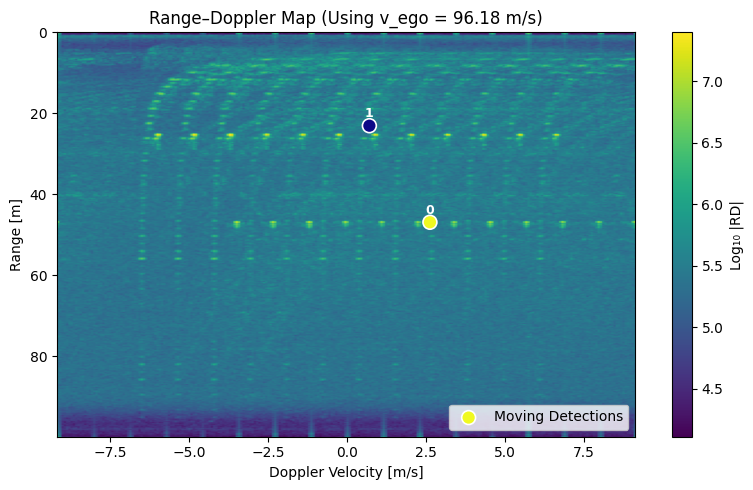

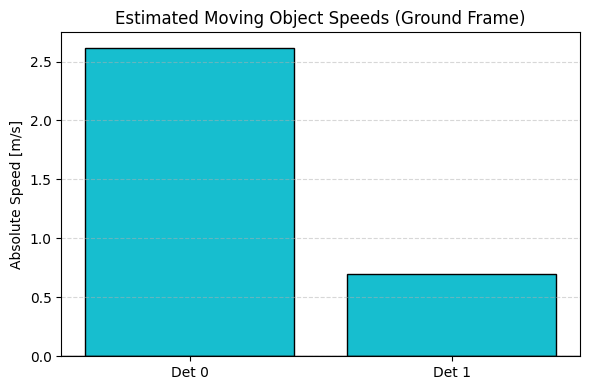

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# --------------------------------------------------
# A) RADAR & PLATFORM PARAMETERS (find correct PRF)
# --------------------------------------------------
v_ego_can_kph = odometry[2]
v_ego_can = v_ego_can_kph * (1000/3600)   # m/s (but we will override it soon!)
c = 3e8
f_c = 77e9
λ = c / f_c                           # radar wavelength ~0.003896 m
frame_time = 0.01356                   # total slow-time block [s]
M = 128                                 # number of chirps per block
PRI_chirp = frame_time / M
PRF_chirp = 1.0 / PRI_chirp            # e.g. ~9442 Hz
N_R, N_D = rd_bf.shape

doppler_freqs = np.fft.fftshift(np.fft.fftfreq(N_D, d=1.0/PRF_chirp))
doppler_vel_axis = (doppler_freqs * λ) / 2.0
range_res = 0.1953125    # <--- set your range resolution [m/bin]
range_axis = np.arange(N_R) * range_res

# --------------------------------------------------
# B) PICK A FAR‐RANGE “STATIC” BIN TO ESTIMATE v_ego
# --------------------------------------------------
STATIC_RANGE_BIN = 400   # choose a bin where you know clutter is static, e.g. r >= 300

# 1) Find the doppler index of the strongest bin at that far‐range:
dop_far = np.abs(rd_bf[STATIC_RANGE_BIN, :])
k_far = np.argmax(dop_far)
f_wrapped_far = doppler_freqs[k_far]

# 2) Suppose you have a separate azimuth‐beamformer that tells you the az‐angle for that bin:
#    For example, say “theta_far” is the angle (in radians) at which you see that clutter.
#    If you do not have a beamformed azimuth, but you know the static clutter is directly ahead,
#    you can set theta_far=0.0.  Otherwise fill in the correct value from your Range–Azimuth map.
theta_far = 0.0     # assume straight‐ahead static clutter

# 3) Search for the integer fold that aligns f_wrapped_far with the expected static‐ego Doppler:
#    f_ego_far_true = -2 * v_ego * cos(theta_far) / λ → we don’t know v_ego yet, so we just search n
best_n_far, best_diff_far = 0, np.inf
# We expect v_ego ~ 15–30 m/s → f_ego_far_true ~ –(2*20)/(0.003896) ≈ –10e3 Hz
# PRF_chirp ≈ 9442 Hz → n will likely be –1 or –2.  So search ±5:
for n_test in range(-5, +6):
    candidate = f_wrapped_far + n_test * PRF_chirp
    # We “guess” f_ego_approx = candidate and call that static (because at far range, that clutter is indeed static)
    # Then we invert f_ego_approx → v_ego_est.
    v_ego_est_test = -(λ / (2.0 * np.cos(theta_far))) * candidate
    # Convert that back to Doppler to see how far from “candidate” it is:
    f_ego_from_vel = -2.0 * v_ego_est_test * np.cos(theta_far) / λ
    diff = abs(f_ego_from_vel - candidate)
    if diff < best_diff_far:
        best_diff_far = diff
        best_n_far = n_test

# Now compute the unwrapped Doppler for that static clutter:
f_unwrapped_far = f_wrapped_far + best_n_far * PRF_chirp

# Invert to get v_ego_true:
v_ego_true = - (λ / (2.0 * np.cos(theta_far))) * f_unwrapped_far
print(f"Static clutter at r={STATIC_RANGE_BIN * range_res:.1f} m, θ={np.rad2deg(theta_far):.1f}° → "
      f"v_ego_true = {v_ego_true:.2f} m/s  (fold n_far = {best_n_far})")

# --------------------------------------------------
# C) RE‐COMPUTE ALL DETECTION VELOCITIES USING v_ego_true
# --------------------------------------------------
v_ego = v_ego_true   # override the CAN value
num_dets = len(dets)

f_wrapped_arr = np.zeros(num_dets)
f_ego_arr = np.zeros(num_dets)
f_unwrapped_arr = np.zeros(num_dets)
best_n_arr = np.zeros(num_dets, dtype=int)
v_obj_arr = np.zeros(num_dets)

for idx, (r_i, theta_i) in enumerate(dets):
    # 1) Wrapped Doppler
    dop_row = np.abs(rd_bf[r_i, :])
    k_i = np.argmax(dop_row)
    f_wrapped = doppler_freqs[k_i]
    f_wrapped_arr[idx] = f_wrapped

    # 2) Ego‐Doppler (static) at that angle (just for plotting/diagnostics):
    f_ego_i = -2.0 * v_ego * np.cos(theta_i) / λ
    f_ego_arr[idx] = f_ego_i

    # 3) Find n so that f_wrapped + n*PRF_chirp ≈ f_ego_i for static (but here they are moving,
    #    so the “best_n” we pick is simply the one that brings us closest to the static estimate).
    best_n, best_diff = 0, np.inf
    for n_test in range(-5, +6):
        candidate = f_wrapped + n_test * PRF_chirp
        diff = abs(candidate - f_ego_i)
        if diff < best_diff:
            best_diff = diff
            best_n = n_test

    best_n_arr[idx] = best_n
    f_unwrapped = f_wrapped + best_n * PRF_chirp
    f_unwrapped_arr[idx] = f_unwrapped

    # 4) Compute the object’s absolute (ground‐frame) velocity:
    #    f_unwrapped = (2/λ) [ v_obj cosθ_i – v_ego cosθ_i ]
    #    →  v_obj = v_ego + (λ/(2 cosθ_i)) * f_unwrapped
    v_obj = v_ego + (λ / (2.0 * np.cos(theta_i))) * f_unwrapped
    v_obj_arr[idx] = v_obj

    print(
        f"Det {idx:2d}: r={r_i}, θ={np.rad2deg(theta_i):5.1f}°  |  "
        f"f_wrapped={f_wrapped:+8.2f} Hz  n={best_n:2d}  f_unwrapped={f_unwrapped:+8.2f} Hz  |  "
        f"v_obj={v_obj:6.2f} m/s"
    )

# --------------------------------------------------
# D) PLOT THE UPDATED RANGE–DOPPLER & OVERLAY MOVING DETECTIONS
# --------------------------------------------------
plt.figure(figsize=(8, 5))
rd_mag = np.log10(np.abs(rd_bf) + 1e-6)
plt.imshow(
    rd_mag,
    extent=[
        doppler_vel_axis.min(), doppler_vel_axis.max(),
        range_axis.max(), range_axis.min()
    ],
    aspect='auto',
    cmap='viridis'
)
plt.colorbar(label='Log₁₀ |RD|')
plt.title(f'Range–Doppler Map (Using v_ego = {v_ego_true:.2f} m/s)')
plt.xlabel('Doppler Velocity [m/s]')
plt.ylabel('Range [m]')

# Overlay detections:
range_m_list = np.array([r_i * range_res for (r_i, _) in dets])
vel_list = v_obj_arr

cmap = plt.cm.plasma
norm = plt.Normalize(vmin=vel_list.min(), vmax=vel_list.max())

plt.scatter(
    vel_list,
    range_m_list,
    c=vel_list,
    cmap=cmap,
    norm=norm,
    s=100,
    edgecolors='white',
    linewidths=1.2,
    label='Moving Detections'
)
for i, (r_i, theta_i) in enumerate(dets):
    plt.annotate(
        f"{i}",
        (vel_list[i], range_m_list[i]),
        textcoords="offset points",
        xytext=(0, 6),
        ha='center',
        color='white',
        fontsize=9,
        weight='bold'
    )

plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# --------------------------------------------------
# E) BAR CHART: ABSOLUTE TARGET VELOCITIES
# --------------------------------------------------
plt.figure(figsize=(6, 4))
indices = np.arange(num_dets)
plt.bar(indices, v_obj_arr, color='tab:cyan', edgecolor='k')
plt.axhline(0, color='k', linewidth=1)
plt.xticks(indices, [f"Det {i}" for i in indices])
plt.ylabel('Absolute Speed [m/s]')
plt.title('Estimated Moving Object Speeds (Ground Frame)')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()